In [39]:
#import library
import os
import numpy as np
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
#import cv2
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

In [40]:
#path to csv data 
path_train = '../data/external/sign_mnist_train.csv'
path_test = '../data/external/sign_mnist_test.csv'

#define image resolution 
res = (28,28)

In [41]:
#convert csv to numpy 
train = np.loadtxt(path_train, delimiter=',', skiprows=1)
test = np.loadtxt(path_test, delimiter=',', skiprows=1)

In [43]:
#printing shape
print(f'Train Shape:{train.shape}')
print(f'Test Shape:{test.shape}')

Train Shape:(27455, 785)
Test Shape:(7172, 785)


In [44]:
#training data
X_train = train[:,1:]
y_train = train[:,0]

#testing data 
X_test = test[:,1:]
y_test = test[:,0]

### Data Augmentation

The extra dimension is added to the image array to represent the batch size for the Keras data generator. The Keras data generator expects an input array of rank 4, where the first dimension represents the batch size.

Since we are passing one image at a time to the data generator, we need to add an extra dimension to the image array to make its shape (1, height, width, channels). The batch size of 1 tells the generator that we are passing one image at a time, and the height and width are the dimensions of the image, while the number of channels represents the color channels of the image.

In [45]:
# Reshape the data to images adding color dimention
X_train = X_train.reshape(X_train.shape[0], res[0], res[1], 1)
X_test = X_test.reshape(X_test.shape[0], res[0], res[1], 1)


In [46]:
# Creating an ImageDataGenerator object with data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest')

In [47]:
# Apply data augmentation to the training set
X_train_augmented = []
y_train_augmented = []
for i in range(X_train.shape[0]):
    img = X_train[i]
    label = y_train[i]
    for j in range(2):
        x_augmented = datagen.random_transform(img)
        X_train_augmented.append(x_augmented)
        y_train_augmented.append(label)

In [62]:
# Apply data augmentation to the test set
X_test_augmented = []
y_test_augmented = []
for i in range(X_test.shape[0]):
    img = X_test[i]
    label = y_test[i]
    for j in range(2):
        x_augmented = datagen.random_transform(img)
        X_test_augmented.append(x_augmented)
        y_test_augmented.append(label)

In [63]:
# Convert the augmented data to numpy arrays
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)
X_test_augmented = np.array(X_test_augmented)
y_test_augmented = np.array(y_test_augmented)

In [64]:
# Save the augmented data to files
np.savez_compressed('../data/external/sign_data_augmented.npz',
                    X_train=X_train_augmented,
                    y_train=y_train_augmented,
                    X_test=X_test_augmented,
                    y_test=y_test_augmented)


In [65]:
# Load the augmented data from the file
data = np.load('../data/external/sign_data_augmented.npz')

# Extract the X_train, y_train, X_test, and y_test arrays from the data
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']


In [66]:
# Print the shapes of the augmented data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (54910, 28, 28, 1)
y_train shape: (54910,)
X_test shape: (14344, 28, 28, 1)
y_test shape: (14344,)


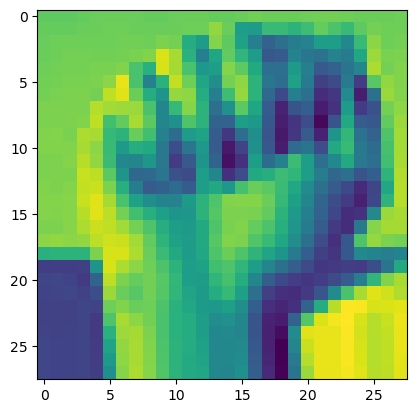

In [67]:
#visualization
import matplotlib.pyplot as plt
plt.imshow(X_test[6]);

In [55]:
# # Define the class names
# class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L','M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X','Y', 'Z']

# # Visualize some of the augmented images
# fig, axes = plt.subplots(2, 5, figsize=(12, 6),
#                          subplot_kw={'xticks': [], 'yticks': []})

# for i, ax in enumerate(axes.flat):
#     ax.imshow(X_train_augmented[i].squeeze(), cmap='gray')
#     ax.set_title(class_names[int(y_train_augmented[i])])

# plt.show()


In [71]:
# Flatten the training data
X_train = X_train_augmented.reshape(X_train.shape[0], -1)

# Flatten the testing data
X_test = X_test_augmented.reshape(X_test.shape[0], -1)

# Print the shapes of the augmented data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (54910, 784)
y_train shape: (54910,)
X_test shape: (14344, 784)
y_test shape: (14344,)


In [72]:
# Create a list of letters for the class labels
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

# Get the unique class labels in y_train_augmented
unique_labels = np.unique(y_train)

# Create a dictionary of class labels
labels = {}
for i in range(len(unique_labels)):
    labels[unique_labels[i]] = letters[i]

In [73]:
# Define a function to find the indices for a given label
def find_indices(data, label):
    # Check if data is a numpy array
    if isinstance(data, np.ndarray):
        # Return the indices
        return np.where(data == label)
    # Check if data is a pandas series
    elif isinstance(data, pd.Series):
        # Return the indices
        return data[data == label].index
    # Otherwise, raise an exception
    else:
        raise Exception('Not supported data type for this function.')


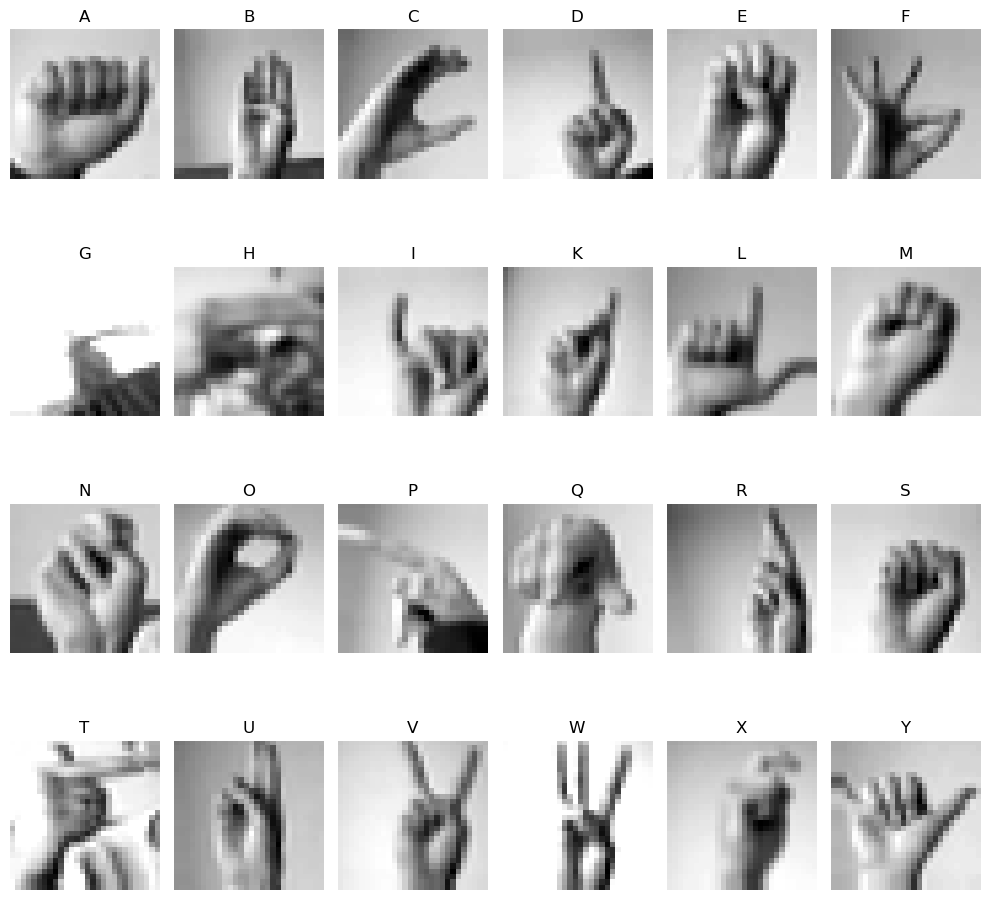

In [79]:
# Create a figure with 5 rows and 5 columns
fig, axs = plt.subplots(4, 6, figsize=(10,10))
axs = axs.ravel()
pos = 0

# Loop through each label and display a random image
for i, label in enumerate(unique_labels):
    # Find the indices for the label
    indices = find_indices(y_train_augmented, label)[0]
    
    # Select a random index
    index = np.random.choice(indices)
    
    # Get the image and the letter
    image = X_train_augmented[index].squeeze()
    letter = labels[label]
    
    # Display the image with the letter as the title
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(letter)
    axs[i].axis('off')
    
# Show the figure
plt.tight_layout()
plt.show()


In [80]:
#standardized data 
#using sklearn standard scaler model and fitting on training data 
sc = StandardScaler().fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

#### Applying naive bayes 

In [81]:
gnb = GaussianNB()

In [82]:
# applying NB on standerdized data
y_pred_sc = gnb.fit(X_train_sc, y_train).predict(X_test_sc)

print(f"Accuracy: {accuracy_score(y_test, y_pred_sc)}")
print("Classification report:")
print(classification_report(y_test, y_pred_sc, target_names=letters))


Accuracy: 0.044966536530953706
Classification report:
              precision    recall  f1-score   support

           A       0.07      0.02      0.03       616
           B       0.03      0.01      0.01       880
           C       0.05      0.03      0.03       624
           D       0.04      0.00      0.01       472
           E       0.08      0.06      0.07      1016
           F       0.05      0.02      0.02       496
           G       0.06      0.04      0.05       656
           H       0.02      0.00      0.00       876
           I       0.03      0.04      0.03       536
           K       0.05      0.04      0.04       684
           L       0.03      0.02      0.02       436
           M       0.02      0.00      0.00       780
           N       0.00      0.00      0.00       560
           O       0.02      0.02      0.02       508
           P       0.05      0.32      0.08       684
           Q       0.02      0.02      0.02       324
           R       0.02    

### Logistic regrassion

In [83]:
lr = LogisticRegression(max_iter=5000)

In [84]:
# testing logistic regression on test data
y_pred_lr_sc = lr.fit(X_train_sc, y_train).predict(X_test_sc)

print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_sc)}")
print("Classification report:")
print(classification_report(y_test, y_pred_lr_sc, target_names=letters))


Accuracy: 0.04155047406581149
Classification report:
              precision    recall  f1-score   support

           A       0.06      0.08      0.07       616
           B       0.05      0.04      0.04       880
           C       0.05      0.05      0.05       624
           D       0.04      0.04      0.04       472
           E       0.07      0.05      0.06      1016
           F       0.03      0.03      0.03       496
           G       0.05      0.05      0.05       656
           H       0.07      0.05      0.06       876
           I       0.02      0.02      0.02       536
           K       0.05      0.04      0.04       684
           L       0.01      0.02      0.02       436
           M       0.04      0.03      0.04       780
           N       0.04      0.04      0.04       560
           O       0.03      0.02      0.02       508
           P       0.05      0.05      0.05       684
           Q       0.02      0.04      0.03       324
           R       0.02     

In [85]:
# testing logistic regression on train data
y_pred_lr = lr.fit(X_train_sc, y_train).predict(X_train_sc)

print(f"Accuracy: {accuracy_score(y_train, y_pred_lr)}")
print("Classification report:")
print(classification_report(y_train, y_pred_lr, target_names=letters))


Accuracy: 0.6060644691313057
Classification report:
              precision    recall  f1-score   support

           A       0.65      0.71      0.68      2252
           B       0.70      0.73      0.72      2020
           C       0.83      0.83      0.83      2288
           D       0.53      0.48      0.51      2392
           E       0.67      0.64      0.66      1914
           F       0.62      0.59      0.61      2408
           G       0.70      0.69      0.69      2180
           H       0.66      0.60      0.63      2026
           I       0.57      0.63      0.60      2324
           K       0.60      0.64      0.62      2228
           L       0.61      0.67      0.64      2482
           M       0.56      0.47      0.51      2110
           N       0.56      0.51      0.53      2302
           O       0.71      0.71      0.71      2392
           P       0.70      0.75      0.73      2176
           Q       0.70      0.73      0.71      2558
           R       0.49      

In [86]:
#normalized data 
X_train_norm = X_train/255 
X_test_norm = X_test/255

In [87]:
# applying logistic regression on normalized data
y_pred_lr_nm = lr.fit(X_train_norm, y_train).predict(X_test_norm)

print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_nm)}")
print("Classification report:")
print(classification_report(y_test, y_pred_lr_nm, target_names=letters))


Accuracy: 0.041201896263245955
Classification report:
              precision    recall  f1-score   support

           A       0.07      0.08      0.07       616
           B       0.05      0.04      0.04       880
           C       0.05      0.05      0.05       624
           D       0.04      0.05      0.04       472
           E       0.07      0.05      0.05      1016
           F       0.02      0.02      0.02       496
           G       0.05      0.05      0.05       656
           H       0.06      0.04      0.05       876
           I       0.02      0.03      0.03       536
           K       0.04      0.04      0.04       684
           L       0.01      0.02      0.02       436
           M       0.03      0.03      0.03       780
           N       0.05      0.05      0.05       560
           O       0.02      0.02      0.02       508
           P       0.05      0.05      0.05       684
           Q       0.02      0.04      0.03       324
           R       0.01    

In [88]:
# applying logistic regression on normalized data
y_pred_lr_nm = lr.fit(X_train_norm, y_train).predict(X_train_norm)

print(f"Accuracy: {accuracy_score(y_train, y_pred_lr_nm)}")
print("Classification report:")
print(classification_report(y_train, y_pred_lr_nm, target_names=letters))


Accuracy: 0.5873429247860135
Classification report:
              precision    recall  f1-score   support

           A       0.61      0.69      0.65      2252
           B       0.68      0.73      0.70      2020
           C       0.82      0.81      0.81      2288
           D       0.51      0.46      0.48      2392
           E       0.65      0.61      0.63      1914
           F       0.59      0.58      0.58      2408
           G       0.69      0.66      0.68      2180
           H       0.64      0.59      0.61      2026
           I       0.55      0.62      0.58      2324
           K       0.58      0.63      0.60      2228
           L       0.58      0.66      0.62      2482
           M       0.55      0.45      0.49      2110
           N       0.55      0.48      0.52      2302
           O       0.70      0.70      0.70      2392
           P       0.68      0.74      0.71      2176
           Q       0.68      0.71      0.69      2558
           R       0.46      